In [12]:
import numpy as np
import pandas as pd
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Load data

In [4]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [5]:
mnist_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/lazyprogrammer/data/mnist.csv', header='infer')

if mnist_df.isna().sum().max() == 0:
  print('There is no NA values')
else:
  print(f'There are {mnist_df.isna().sum().max()} NAs' )

print(mnist_df.info())
mnist_df.head(10)

There is no NA values
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
RANDOM_STATE = 123

def _get_mnist_data_raw():
    print("Reading in and transforming data...")
    df = mnist_df
    data = df.values
    X = data[:, 1:].astype(np.float32)
    Y = data[:, 0].astype(int)
    assert X.shape[1] == 28 * 28
    picture_shape = (28, 28)
    return X, Y, picture_shape


def get_mnist_normalized_data(train_size=0.8, should_plot_examples=True):
    assert train_size != 0
    X, Y, picture_shape = _get_mnist_data_raw()

    if 0.0 < train_size < 1.0:
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1-train_size, random_state=RANDOM_STATE)
    elif train_size == 1:
        X_train, Y_train = shuffle(X, Y, random_state=RANDOM_STATE)
        X_test, Y_test = None, None
    else:
        if isinstance(train_size, int):
            X, Y = shuffle(X, Y, random_state=RANDOM_STATE)
            X_train, Y_train = X[:train_size, :], Y[:train_size]
            X_test, Y_test = X[train_size:, :], Y[train_size:]
        else:
            raise Exception(f'Wrong test size value or type. Value:{train_size}, type:{type(train_size)}')

    # normalize the data
    mu = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    np.place(std, std == 0, 1)
    X_train = (X_train - mu) / std
    X_test = (X_test - mu) / std

    if should_plot_examples:
        plot_examples(X.reshape((-1, *picture_shape)), Y, cmap='gray', labels=None)
    return X_train, X_test, Y_train, Y_test, picture_shape


def plot_examples(x, y, cmap='gray', labels=None):
    plt.figure(figsize=(15, 15))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x[i], cmap=cmap)
        if labels is None:
            plt.xlabel(y[i])
        else:
            plt.xlabel(labels[y[i]])
    plt.show()

# Utils

In [18]:
def error_rate(p, t):
    return np.mean(p != t)


def relu(a):
    return a * (a > 0)


def ndarray_one_hot_encode(vec, width):
    assert isinstance(vec, np.ndarray)
    assert len(vec.shape) == 1
    n = vec.shape[0]
    mat = np.zeros((n, width))
    mat[np.arange(n), vec] = 1
    return mat

In [50]:
def optimize_2l_nn(Xtrain, Xtest, Ytrain_ind, Ytest_ind, K, learning_rate, n_epochs=100, batch_size=500, reg=0.01):
    print_period = 10

    N, D = Xtrain.shape
    n_batches = N // batch_size

    M = 300
    W1_init = np.random.randn(D, M) / np.sqrt(D)
    b1_init = np.zeros(M)
    W2_init = np.random.randn(M, K) / np.sqrt(M)
    b2_init = np.zeros(K)

    # define theano variables and expressions
    thX = T.matrix('X')
    thT = T.matrix('T')
    W1 = theano.shared(W1_init, 'W1')
    b1 = theano.shared(b1_init, 'b1')
    W2 = theano.shared(W2_init, 'W2')
    b2 = theano.shared(b2_init, 'b2')

    # use the built-in theano functions to do relu and softmax
    thZ = relu( thX.dot(W1) + b1 ) # let's do it via numpy however relu is new in version 0.7.1
    thY = T.nnet.softmax( thZ.dot(W2) + b2 )

    # define the cost and prediction functions
    cost = -(thT * T.log(thY)).mean() + reg*((W1*W1).sum() + (b1*b1).sum() + (W2*W2).sum() + (b2*b2).sum())
    prediction = T.argmax(thY, axis=1)

    # define update parameters expressions using automatic differentiation (this includes also regularizatrion)
    update_W1 = W1 - learning_rate * T.grad(cost, W1)
    update_b1 = b1 - learning_rate * T.grad(cost, b1)
    update_W2 = W2 - learning_rate * T.grad(cost, W2)
    update_b2 = b2 - learning_rate * T.grad(cost, b2)

    # builds computation graph with 4 parameters to update by different update expressions
    train = theano.function(
        inputs=[thX, thT],
        updates=[(W1, update_W1), (b1, update_b1), (W2, update_W2), (b2, update_b2)],
    )

    # create another function graph for this because we want it over the whole dataset
    get_prediction = theano.function(
        inputs=[thX, thT],
        outputs=[cost, prediction],
    )

    costs = []
    for i in range(n_epochs):
        Xtrain_shuffled, Ytrain_ind_shuffled = shuffle(Xtrain, Ytrain_ind)
        for j in range(n_batches):
            Xbatch = Xtrain_shuffled[j*batch_size:(j*batch_size + batch_size),]
            Ybatch = Ytrain_ind_shuffled[j*batch_size:(j*batch_size + batch_size),]

            train(Xbatch, Ybatch)
            if j % print_period == 0:
                cost_val, prediction_val = get_prediction(Xtest, Ytest_ind)
                err = error_rate(prediction_val, Ytest)
                print(f'Epoch:{i}, batch:{j}, cost={cost_val}, error rate={err}')
                costs.append(cost_val)

    plt.plot(costs)
    plt.show()


# Calculations

In [51]:
Xtrain, Xtest, Ytrain, Ytest, picture_shape = get_mnist_normalized_data(train_size=-1000, should_plot_examples=False)
assert Xtrain.shape[1] == picture_shape[0] * picture_shape[1]

K = 10
Xtrain = Xtrain.astype(np.float32)
Ytrain = Ytrain.astype(np.int32)
Xtest = Xtest.astype(np.float32)
Ytest = Ytest.astype(np.int32)
Ytrain_ind = ndarray_one_hot_encode(Ytrain, K).astype(np.int32)
Ytest_ind = ndarray_one_hot_encode(Ytest, K).astype(np.int32)

Reading in and transforming data...


Epoch:0, batch:0, cost=3.338074157697394, error rate=0.89
Epoch:0, batch:10, cost=3.322082677673236, error rate=0.875
Epoch:0, batch:20, cost=3.306133049771733, error rate=0.853
Epoch:0, batch:30, cost=3.290507379661554, error rate=0.838
Epoch:0, batch:40, cost=3.2749696054314925, error rate=0.823
Epoch:0, batch:50, cost=3.259587150932964, error rate=0.811
Epoch:0, batch:60, cost=3.2443846767934343, error rate=0.794
Epoch:0, batch:70, cost=3.229386887754999, error rate=0.771
Epoch:0, batch:80, cost=3.214506472308894, error rate=0.759
Epoch:1, batch:0, cost=3.211552794671123, error rate=0.751
Epoch:1, batch:10, cost=3.1968522476822585, error rate=0.731
Epoch:1, batch:20, cost=3.1822816364935878, error rate=0.702
Epoch:1, batch:30, cost=3.1678639768510433, error rate=0.689
Epoch:1, batch:40, cost=3.1535693095379176, error rate=0.674
Epoch:1, batch:50, cost=3.1394349525891267, error rate=0.654
Epoch:1, batch:60, cost=3.125405392298958, error rate=0.632
Epoch:1, batch:70, cost=3.1115107050

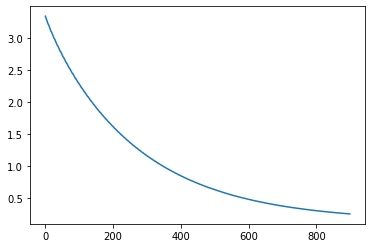

In [53]:
optimize_2l_nn(Xtrain, Xtest, Ytrain_ind, Ytest_ind, K, learning_rate=0.01, n_epochs=100, batch_size=500, reg=0.01)